In [1]:
import pandas as pd
import numpy as np
import glob
from IPython.display import clear_output

batch_size = 80
max_iter = 50
active_col = 'PstP True Active'
pains_col = 'Passes PAINS Filter'
cluster_col = 'BT_0.4 ID'
pstp_iter_file = '../../ALDD-PstP-Results/results/setting_true/training_data/cumulative_50.csv.gz'

pstp_true_file = '../datasets/pstp_final_true_with_pains.csv.gz'
true_df = pd.read_csv(pstp_true_file)

res_list = []
for i in range(max_iter):
    tmp_df = pd.read_csv('../../ALDD-PstP-Results/results/setting_true/next_batch/iter_{}.csv.gz'.format(i))
    tmp_df['iter_num'] = i
    res_list.append(tmp_df)
    
tmp_df = pd.concat(res_list)[['Index ID', 'iter_num']]
res_df = pd.read_csv(pstp_iter_file)
res_df = pd.merge(tmp_df, res_df, on='Index ID')
assert tmp_df['Index ID'].unique().shape[0] == batch_size*max_iter
assert res_df['Index ID'].unique().shape[0] == batch_size*max_iter

# add ata
ata_df = res_df[res_df['Molecule'].str.contains('ATA')].copy()
ata_df[pains_col] = 1
res_df = res_df.merge(true_df[['Molecule', pains_col]], on='Molecule')
res_df = pd.concat([ata_df, res_df])
true_df = pd.concat([ata_df[true_df.columns], true_df])

In [2]:
screened_actives_df = res_df[(res_df[active_col] == 1)]
true_actives_df = true_df[(true_df[active_col] == 1)]
total_hits, total_unique_hits = screened_actives_df.shape[0], screened_actives_df[cluster_col].unique().shape[0]
dataset_size, screened_size = true_df.shape[0], res_df.shape[0] 
true_total_hits, true_total_unique_hits = true_actives_df.shape[0], true_actives_df[cluster_col].unique().shape[0]
fraction_screened, fraction_hits_found, fraction_uhits_found = screened_size/dataset_size, total_hits/true_total_hits, total_unique_hits/true_total_unique_hits
hit_perc = true_total_hits/dataset_size
hits_expected = screened_size*(true_total_hits/dataset_size)

print('Batch size: {}. # iters: {}. Total selected cpds: {}.'.format(batch_size,  max_iter, screened_size))
print('Dataset size: {}. Total hits in dataset: {}. Total unique hits in dataset: {}'.format(dataset_size, true_total_hits, true_total_unique_hits))
print('Hit %: {:.2f}%. Hits expected in {} cpds: {:.2f} hits.'.format(100.0*hit_perc, screened_size, hits_expected))
print('Total hits found: {}. Total unique hits found: {}.'.format(total_hits, total_unique_hits))
print('Percent of dataset screened: {:.2f}%. Percent of hits found: {:.2f}%. Percent of unique hits found: {:.2f}%.'.format(100*fraction_screened, 
                                                                               100*fraction_hits_found,
                                                                               100*fraction_uhits_found))

Batch size: 80. # iters: 50. Total selected cpds: 4000.
Dataset size: 94044. Total hits in dataset: 143. Total unique hits in dataset: 127
Hit %: 0.15%. Hits expected in 4000 cpds: 6.08 hits.
Total hits found: 29. Total unique hits found: 27.
Percent of dataset screened: 4.25%. Percent of hits found: 20.28%. Percent of unique hits found: 21.26%.


---
# Uniform Random Sampling of Training Set 

In [55]:
import time
import pathlib
import warnings
warnings.filterwarnings('ignore')

output_file_fmt = '../datasets/pstp/one_round_screening/random/size_{}/sample_{}/train.csv.gz'
max_size = 4000
seeds_list = [55886611, 91555713, 10912561, 69210899, 75538109, 
              33176925, 17929553, 26974345, 63185387, 54808003]
sample_size_list = (max_size*np.linspace(0.1, 0.9, 9)).astype(int)

start_time = time.time()

for sample_size in sample_size_list:
    for seed_idx, seed in enumerate(seeds_list):
        train_file = output_file_fmt.format(sample_size, seed_idx)
        pathlib.Path(train_file).parent.mkdir(parents=True, exist_ok=True)
        
        np.random.seed(seed)
        cpds_to_select = np.random.choice(dataset_size, replace=False, size=sample_size)
        cpds_to_select[0] = 0 # add ATA instead of first sample cpd
        
        sample_df = true_df.iloc[cpds_to_select,:]
        sample_df.to_csv(train_file, compression='gzip', index=False)
        
        assert sample_df['Molecule'].isin(['CID2259_ATA']).sum() == 1
        
        print('Sampled {} compounds with seed {}.'.format(sample_df.shape[0], seed))
    
    print('---------------------------------------------------------------------------')
    
print('Total time {} minutes.'.format((time.time() - start_time)/60.0))

Sampled 400 compounds with seed 55886611.
Sampled 400 compounds with seed 91555713.
Sampled 400 compounds with seed 10912561.
Sampled 400 compounds with seed 69210899.
Sampled 400 compounds with seed 75538109.
Sampled 400 compounds with seed 33176925.
Sampled 400 compounds with seed 17929553.
Sampled 400 compounds with seed 26974345.
Sampled 400 compounds with seed 63185387.
Sampled 400 compounds with seed 54808003.
---------------------------------------------------------------------------
Sampled 800 compounds with seed 55886611.
Sampled 800 compounds with seed 91555713.
Sampled 800 compounds with seed 10912561.
Sampled 800 compounds with seed 69210899.
Sampled 800 compounds with seed 75538109.
Sampled 800 compounds with seed 33176925.
Sampled 800 compounds with seed 17929553.
Sampled 800 compounds with seed 26974345.
Sampled 800 compounds with seed 63185387.
Sampled 800 compounds with seed 54808003.
---------------------------------------------------------------------------
Sampled 

---
# Diversity (Tanimito Dissimilarity) Sampling of Training Set 

In [102]:
import time
import pathlib
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin
import warnings
warnings.filterwarnings('ignore')

output_file_fmt = '../datasets/pstp/one_round_screening/diversity/size_{}/sample_0/train.csv.gz'
max_size = 4000
sample_size_list = (max_size*np.linspace(0.1, 0.9, 9)).astype(int)

for sample_size in sample_size_list:
    start_time = time.time()
    cpds_to_select = [0] # select first compound as ATA 
    train_file = output_file_fmt.format(sample_size)
    pathlib.Path(train_file).parent.mkdir(parents=True, exist_ok=True)
    
    X_prosp = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in true_df['Morgan FP_2_1024']]).astype(float)
    for i in range(1, sample_size):
        x = X_prosp[cpds_to_select,:]
        remaining_cpds = np.setdiff1d(np.arange(X_prosp.shape[0]), cpds_to_select)
        y = X_prosp[remaining_cpds,:]
        
        # adapted from: https://github.com/deepchem/deepchem/blob/2531eca8564c1dc68910d791b0bcd91fd586afb9/deepchem/trans/transformers.py#L752
        numerator = np.dot(y, x.T).flatten() # equivalent to np.bitwise_and(X_batch, Y_batch), axis=1)
        denominator = 1024 - np.dot(1-y, (1-x).T).flatten() # np.sum(np.bitwise_or(X_rep, Y_rep), axis=1)

        tandist = numerator / denominator
        tandist = 1.0 - tandist

        tandist = tandist.reshape(y.shape[0], -1)
        
        mean_dist_to_selected = tandist.mean(axis=1)
        farthest_idx = np.argmax(mean_dist_to_selected)

        cpds_to_select.append(remaining_cpds[farthest_idx])

    sample_df = true_df.iloc[cpds_to_select,:]
    sample_df.to_csv(train_file, compression='gzip', index=False)
    
    assert sample_df['Molecule'].isin(['CID2259_ATA']).sum() == 1
    
    print('Diversity sampled {} compounds. Time {} minutes.'.format(sample_size, (time.time() - start_time)/60.0))

Diversity sampled 400 compounds. Time 8.631892410914103 minutes.
Diversity sampled 800 compounds. Time 26.711431741714478 minutes.
Diversity sampled 1200 compounds. Time 52.85286370118459 minutes.
Diversity sampled 1600 compounds. Time 85.9373074054718 minutes.
Diversity sampled 2000 compounds. Time 127.61310313542684 minutes.
Diversity sampled 2400 compounds. Time 177.2579901178678 minutes.
Diversity sampled 2800 compounds. Time 234.9540247162183 minutes.
Diversity sampled 3200 compounds. Time 300.3853029648463 minutes.
Diversity sampled 3600 compounds. Time 374.5990753809611 minutes.


In [ ]:
line1 = 'JOB PSTP_ORS_{} pstp.sub'
line2 = 'VARS PSTP_ORS_{} args="{} {}" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code6.tar.gz" transfer_output_files="./results_{}.tar.gz" hpname="PSTP_ORS_{}" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pstp.log"'
line3 = 'SCRIPT POST PSTP_ORS_{} ./post_job_script.sh ./results_{}.tar.gz'

output_file_fmt = '../datasets/pstp/one_round_screening/random/size_{}/sample_{}/'
max_size = 4000
sample_size_list = (max_size*np.linspace(0.1, 0.9, 9)).astype(int)

job_num = 0
# random sampling
for sample_size in sample_size_list:
    for seed_idx in range(10):
        train_dir = output_file_fmt.format(sample_size, seed_idx)
        
        print(line1.format(job_num))
        print(line2.format(job_num, train_dir, job_num, job_num, job_num))
        print(line3.format(job_num, job_num))
        
        job_num = job_num + 1

# diversity sampling
output_file_fmt = '../datasets/pstp/one_round_screening/diversity/size_{}/sample_0/'
sample_size_list = (max_size*np.linspace(0.1, 0.9, 9)).astype(int)

for sample_size in sample_size_list:
    train_dir = output_file_fmt.format(sample_size)
    
    print(line1.format(job_num))
    print(line2.format(job_num, train_dir, job_num, job_num, job_num))
    print(line3.format(job_num, job_num))

    job_num = job_num + 1

---
# Process Results

In [48]:
import pandas as pd
import numpy as np
import glob
from IPython.display import clear_output

max_size = 4000
res_list = []

output_file_fmt = '../datasets/pstp/one_round_screening/results/one_round_screening/{}/size_{}/sample_{}/'
sampling_type_list = ['random', 'diversity']
sample_size_list = (max_size*np.linspace(0.1, 0.9, 9)).astype(int)

for sampling_type in sampling_type_list:
    for sample_size in sample_size_list:
        num_samples = 1
        if sampling_type == 'random':
            num_samples = 10
        for seed_idx in range(num_samples):
            results_dir = output_file_fmt.format(sampling_type, sample_size, seed_idx)
            train_file = results_dir + '/train.csv.gz'
            selected_file = results_dir + '/selected.csv.gz'

            train_df = pd.read_csv(train_file)
            selected_df = pd.read_csv(selected_file)
            selected_df = selected_df.merge(true_df[['Molecule', 'Passes PAINS Filter']], on='Molecule')

            train_hits = train_df[train_df['PstP True Active'] == 1]
            train_hits = train_hits[train_hits['Passes PAINS Filter'] == 1]
            selected_hits = selected_df[selected_df['PstP True Active'] == 1]
            selected_hits = selected_hits[selected_hits['Passes PAINS Filter'] == 1]

            total_hits = train_hits.shape[0] + selected_hits.shape[0]
            total_unique_hits = train_hits['BT_0.4 ID'].shape[0] + selected_hits['BT_0.4 ID'].shape[0]

            curr_results = [sampling_type, sample_size, seed_idx, 
                            train_hits.shape[0], selected_hits.shape[0], total_hits, total_unique_hits]
            res_list.append(curr_results)
            
res_df = pd.DataFrame(data=res_list, 
                      columns=['Sampling Type', 'Sample Size', 'Sample Replicate', 
                               'Train Hits', 'Selected Hits', 'Total Hits', 'Total Unique Hits'])

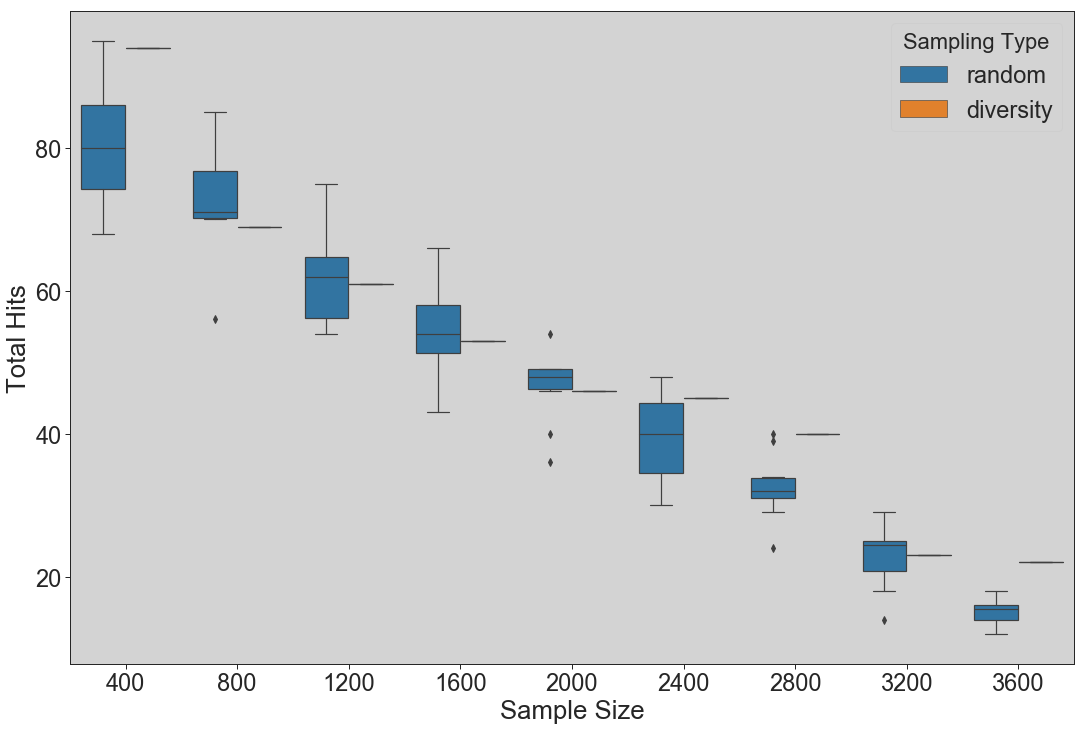

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks", rc={'axes.facecolor':'lightgrey'})
sns.set_context("paper", font_scale=2.68)
figsize=(18, 12)

plt.figure(figsize=figsize)

sns.boxplot(x='Sample Size', y='Total Hits', hue='Sampling Type', data=res_df)

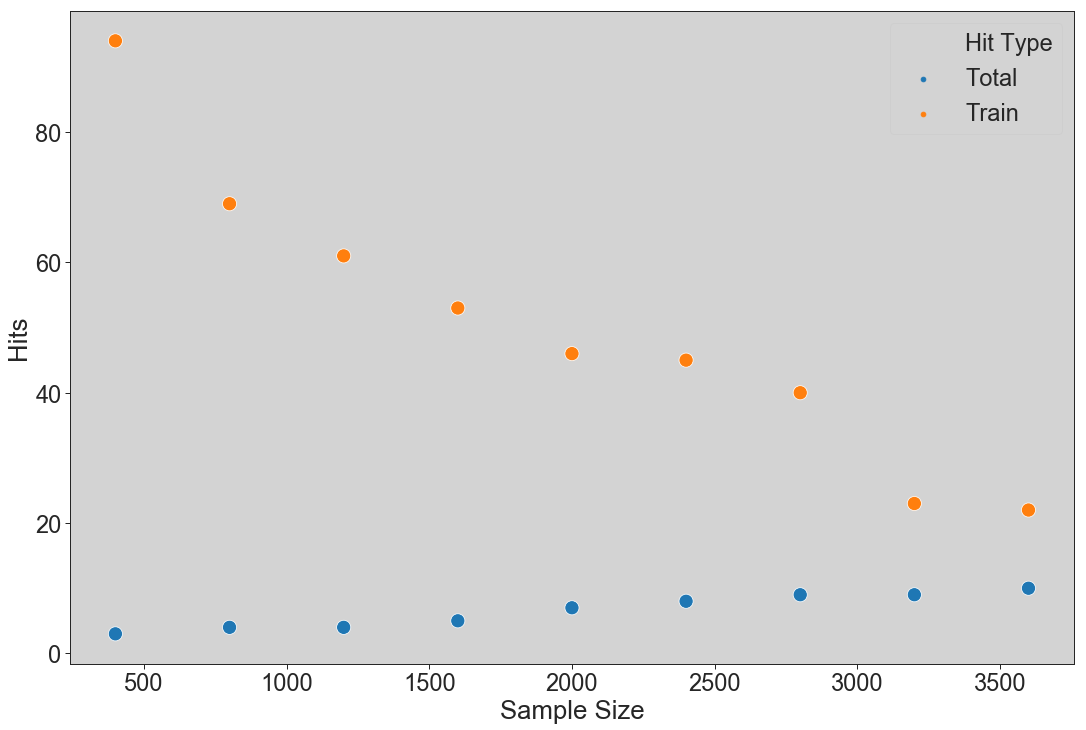

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks", rc={'axes.facecolor':'lightgrey'})
sns.set_context("paper", font_scale=2.68)
figsize=(18, 12)

plt.figure(figsize=figsize)

diversity_df1 = res_df[res_df['Sampling Type'] == 'diversity']
diversity_df1['Hit Type'] = 'Train'
diversity_df2 = diversity_df1.copy()
diversity_df1['Hit Type'] = 'Total'

diversity_df1['Hits'] = diversity_df1['Train Hits']
diversity_df2['Hits'] = diversity_df1['Total Hits']

data_df = pd.concat([diversity_df1, diversity_df2])

sns.scatterplot(x='Sample Size', y='Hits', hue='Hit Type', data=data_df, s=200)